# DSC 630

#### Week 3: Assignment 3.4

Author: Bryce Kirby<br>


In this assignment, you will be using data on the Los Angeles Dodgers Major League Baseball (MLB) team located here: dodgers.csv. Use this data to make a recommendation to management on how to improve attendance. Tell a story with your analysis and clearly explain the steps you take to arrive at your conclusion. This is an open-ended question, and there is no one right answer. You are welcome to do additional research and/or use domain knowledge to assist your analysis, but clearly state any assumptions you make.


#### Load data

In [2]:
# required to pre-load for piping
library('magrittr')

# set plot size
options(plot.height=3, plot.width=3)

# define data directory
dirdata <- paste(getwd(),'data',sep='/')

# load dodgers data file
dodgers_raw <- read.csv(paste(dirdata,'dodgers.csv',sep='/'))

#### Exploratory Data Analysis

In [2]:
# check data sample
head(dodgers_raw)

month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead
<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,NO,NO
APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,NO,NO
APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,NO,NO
APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,YES,NO
APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,NO,NO
APR,15,38359,Sunday,Padres,65,Clear,Day,NO,NO,NO,NO


In [20]:
# we need to order the day of the week to plot meaningfully
dodgers_raw$day_of_week <- factor(dodgers_raw$day_of_week, levels = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))

# we need to order the months to plot meaningfully
dodgers_raw$month <- factor(dodgers_raw$month, levels = c("APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT"))

Check categorical columns

In [21]:
# examine the data through descriptive statistics
Hmisc::describe(dodgers_raw)

dodgers_raw 

 12  Variables      81  Observations
--------------------------------------------------------------------------------
month 
       n  missing distinct 
      81        0        7 
                                                    
Value        APR   MAY   JUN   JUL   AUG   SEP   OCT
Frequency     12    18     9    12    15    12     3
Proportion 0.148 0.222 0.111 0.148 0.185 0.148 0.037
--------------------------------------------------------------------------------
day 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
      81        0       31    0.998    16.14     11.1        2        3 
     .25      .50      .75      .90      .95 
       8       15       25       29       30 

lowest :  1  2  3  4  5, highest: 27 28 29 30 31
--------------------------------------------------------------------------------
attend 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
      81        0       80        1    41040     9525    

Therefore, the observations are:
* Promotion ranges from April to August
* There are 4 types of promotions, e.g. Cap, Shirt, Fireworks, Bobblehead
* Data is divided in seven days of the week
* Highest attendence is 56000


**Attendence by day**

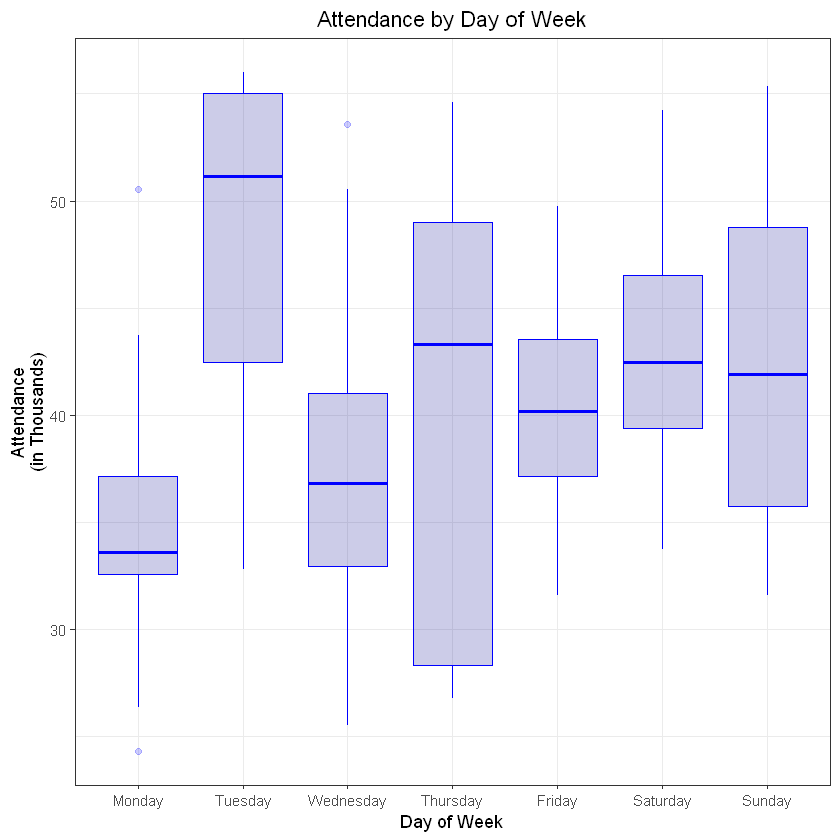

In [27]:
ggplot2::ggplot(dodgers_raw, ggplot2::aes(x=day_of_week, y=attend/1000)) + 
    ggplot2::geom_boxplot(color="blue", fill="darkblue", alpha=0.2) +
    ggplot2::labs(title='Attendance by Day of Week',
                 x='Day of Week',
                 y='Attendance\n(in Thousands)') +
    ggplot2::theme_bw() +
    ggplot2::theme(plot.title = ggplot2::element_text(hjust = 0.5))

Looks like **Tuesday's** are the highest attendence days since the median is the highest and **Monday's** are the lowest attendence days. The first assumption is, promotions morstly happened on Tuesdays.

**Attendence by Month**

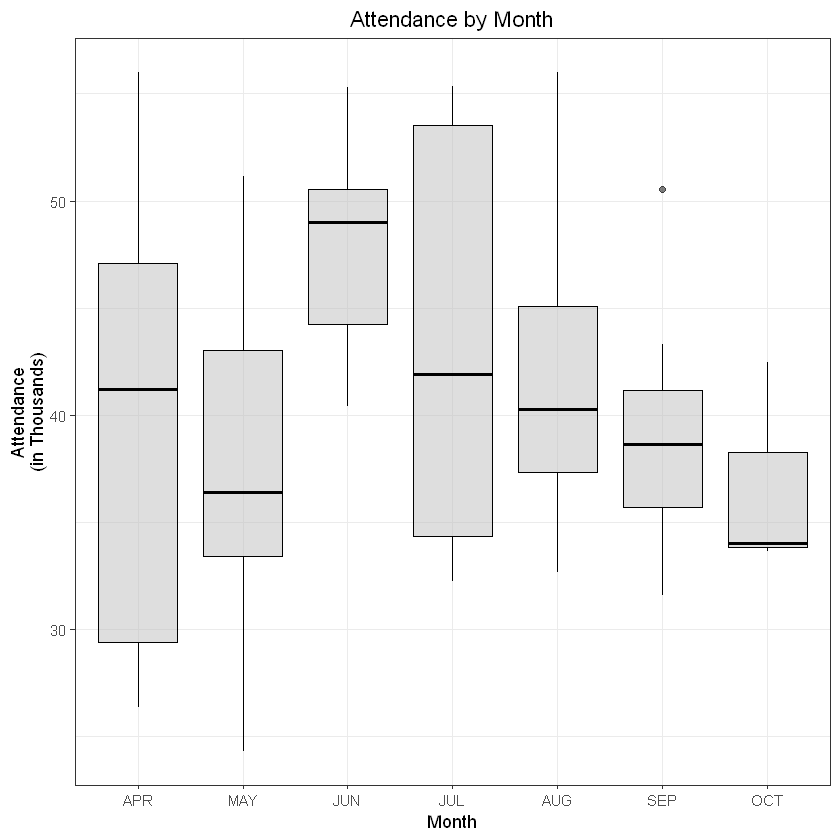

In [28]:
ggplot2::ggplot(dodgers_raw, ggplot2::aes(x=month, y=attend/1000)) + 
    ggplot2::geom_boxplot(color="black", fill="grey", alpha=0.5) +
    ggplot2::labs(title='Attendance by Month',
                 x='Month',
                 y='Attendance\n(in Thousands)') +
    ggplot2::theme_bw() +
    ggplot2::theme(plot.title = ggplot2::element_text(hjust = 0.5))

**June** seems to be the highest attendence month since the median is the highest. **October** seems to be the lowest attendence month.

**Attendance by Weather**

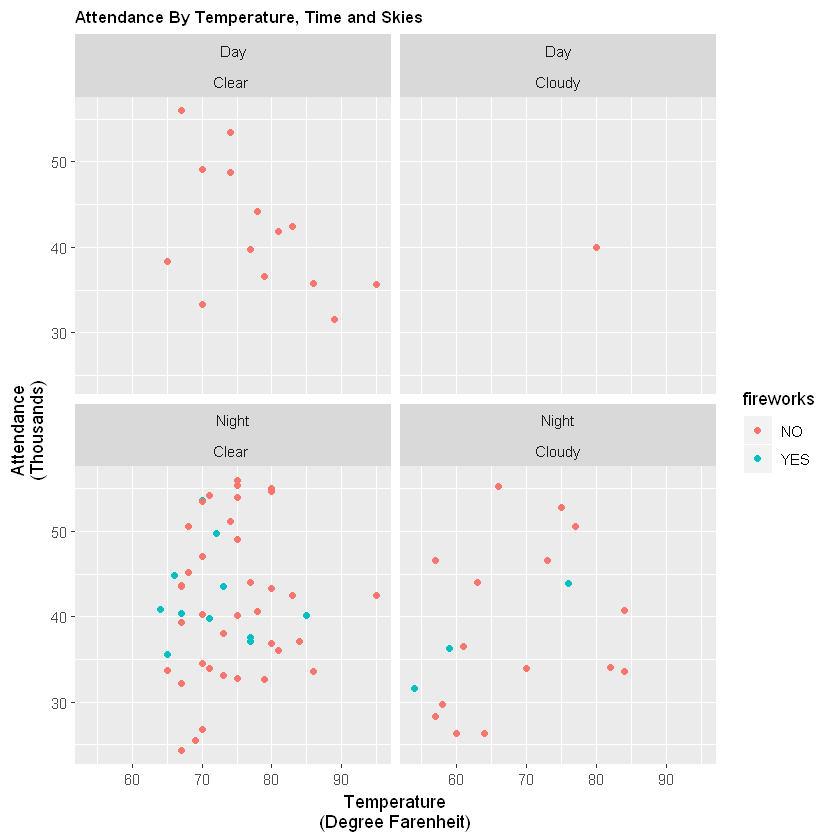

In [34]:
ggplot2::ggplot(dodgers_raw, ggplot2::aes(x=temp, y=attend/1000, color=fireworks)) + 
    ggplot2::geom_point() + 
    ggplot2::facet_wrap(day_night~skies) + 
    ggplot2::theme(plot.title = ggplot2::element_text(lineheight=3, face="bold", color="black", size=10)) +
    ggplot2::labs(title='Attendance By Temperature, Time and Skies',
                  x='Temperature\n(Degree Farenheit)',
                  y='Attendance\n(Thousands)')

* In day games with clear sky, most of the attendance vary between 70&deg;F to 80&deg;F.
* There was only one day game played under cloudy sky. Hence we do not have enough observation of that case.
* Most games were played at night with clear sky, and it constantly attained a high attendance.
* Games played at night under cloudy sky are distributed between crowd puller and empty house.

Next I would like to see if location and reputation of the opponent teams have any impact on the overall attendance.

**Attendance by opponent teams**

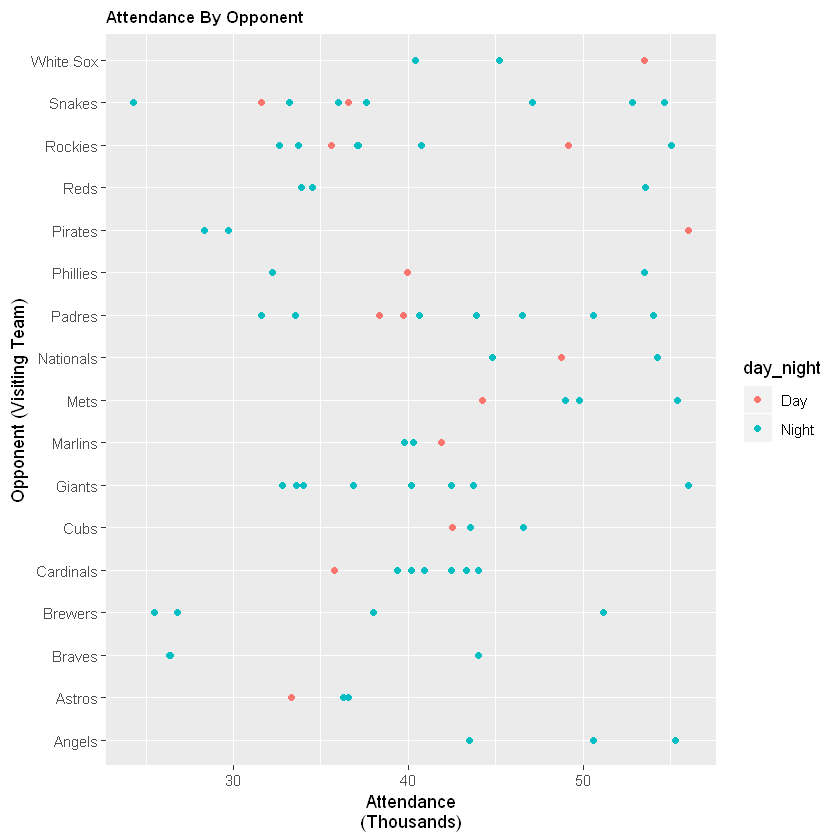

In [7]:
#Strip Plot of Attendance by opponent or visiting team
ggplot2::ggplot(dodgers_raw, ggplot2::aes(x=attend/1000, y=opponent, color=day_night)) + 
        ggplot2::geom_point() + 
        ggplot2::labs(title = 'Attendance By Opponent',                      
                      x='Attendance\n(Thousands)',
                      y='Opponent (Visiting Team)') +
        ggplot2::theme(plot.title = ggplot2::element_text(lineheight=3, face="bold", color="black", size=10))

Games where the opponents were from bigger cities or larger metro areas, e.g. Angels from Los Angeles, New York New York, Chicago Cubs etc., has a consistently higher attendance.



To measure the impact of a promotion on attendance, I am building a Linear Model. The intention is to predict the attendance using Month, Day of Week and promotion (Bobblehead) indicator.

Discuss model significance

In [3]:
# since we are trying to check effect of month, day of week and bobblehead on attendance, defnie a model accordingly
dodger.model <- {attend ~ month + day_of_week + bobblehead}

# reseed for repeatability
set.seed(1234)
traintest_key <- c(rep(1, trunc((2/3)*nrow(dodgers_raw))), rep(2, trunc((1/3)*nrow(dodgers_raw))))

# create a variable in main data to separate test and train later
dodgers_raw$train_test <- sample(traintest_key)

# split test train withing dataset and assign label
dodgers_raw$train_test <- factor(dodgers_raw$train_test, levels = c(1, 2), labels = c("TRAIN", "TEST"))


train <- subset(dodgers_raw, train_test == "TRAIN")
test <- subset(dodgers_raw, train_test == "TEST")

# model fit on training data
model.fit.train <- lm(dodger.model, data = train)

# predict from Training Set
train$attend_pred <- predict(model.fit.train)

# model evaluation on test set
test$attend_pred <- predict(model.fit.train, newdata = test)

# calculate accuracy on test data
accuracy <- round(cor(test$attend, test$attend_pred)^2, digits=3)

# compute the proportion of response variance accounted for when predicting Test Data
print(accuracy)

[1] 0.453


In [9]:
# estimate attendance based on full dataset
dodgers_predicted <- train %>% dplyr::bind_rows(test)
model.fit.all <- lm(dodger.model, data = dodgers_raw)

# evaluate model performance
print(summary(model.fit.all))


Call:
lm(formula = dodger.model, data = dodgers_raw)

Residuals:
     Min       1Q   Median       3Q      Max 
-10786.5  -3628.1   -516.1   2230.2  14351.0 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          38792.98    2364.68  16.405  < 2e-16 ***
monthAUG              2377.92    2402.91   0.990   0.3259    
monthJUL              2849.83    2578.60   1.105   0.2730    
monthJUN              7163.23    2732.72   2.621   0.0108 *  
monthMAY             -2385.62    2291.22  -1.041   0.3015    
monthOCT              -662.67    4046.45  -0.164   0.8704    
monthSEP                29.03    2521.25   0.012   0.9908    
day_of_weekMonday    -4883.82    2504.65  -1.950   0.0554 .  
day_of_weekSaturday   1488.24    2442.68   0.609   0.5444    
day_of_weekSunday     1840.18    2426.79   0.758   0.4509    
day_of_weekThursday  -4108.45    3381.22  -1.215   0.2286    
day_of_weekTuesday    3027.68    2686.43   1.127   0.2638    
day_of_weekWednesday 

My interpretation from the summary:

* **t-value**: The coefficient `t-value` is a measure of how many standard deviations our coefficient estimate is far away from 0. In this case, overall t-values are not that far away from 0, meaning, a relationship exists between te variables.

* **p-value**: The `p-value` is significantly low, meaning there is very less probability that the result of the statistical test is by chance. In other words, true relationship exists between the variables.

* **R-Squared**: The `R-squared` value is 0.544, which means 54.4% of the vartiance found in the response variable can be explained by the predictor variable.

To find out the effect of the promotion on attendance, I would like to extract the below number

In [13]:
print(round(model.fit.all$coefficients[length(model.fit.all$coefficients)], digits = 0))

bobbleheadYES 
        10715 


#### Conclusion

Looking at all the metrices, we can predict and quantify the effect of bobblehead promotion on the attendance of a match. As far as marketing is concerned, attaching financial criteria with the findings can provide the Dodgers revenue and effect of promotion on that.

#### Reference

www.rpubs.com